In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import textwrap

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patheffects as pe

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, make_cmap, plot_terrain
from constants import ucsd_colors
import customcmaps as ccmap

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
server = 'skyriver'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
casename = 'nov2023' # 'dec2020' or 'nov2023'
if casename == 'dec2020':
    ## load ERA5 IVT data for Dec 1, 2020 06 UTC
    month = '12'
    day = '01' 
    year = '2020'
    date = '2020-12-01 06' 
elif casename == 'nov2023':
    ## load ERA5 IVT data
    month = '11' 
    day = '20' 
    year = '2023' 
    date = '2023-11-20 18' 

if server == 'expanse':
    fname = '/home/dnash/DATA/preprocessed/ERA5/ivt/{0}{1}_IVT.nc'.format(year, month)
elif server == 'skyriver':
    fname = '/data/downloaded/Reanalysis/ERA5/{0}/{2}/ERA5_{0}_{2}{1}{3}.nc'.format('IVT', month, year, day)

ds = xr.open_dataset(fname)
ds = ds.sel(time=date)
ds

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
Struct() takes at most 1 argument (3 given)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
    time     datetime64[ns] 2023-11-20T18:00:00
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Data variables:
    IVT      (lat, lon) float64 ...
    uIVT     (lat, lon) float64 ...
    vIVT     (lat, lon) float64 ...
    IWV      (lat, lon) float64 ...
Attributes:
    Conventions:  CF-1/0

In [4]:
ext = [-155., -125., 45., 61.] # extend of AK
colors = ['#ffe503', '#ffe503', '#ffaf02', '#ff8301', '#ff8301', '#ffaf02']
direction = [210, 210, 180, 210, 180, 210]
ivt = [356, 344, 518, 662, 630, 535]
xs = [-135.3277, -135.8894, -139.671, -133.1358, -132.4009, -135.4519]
ys = [59.4538, 59.3988, 59.5121, 55.4769, 55.5400, 58.1122]
lbl1 = ['Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan', 'Hoonah']
distance = [16, 13, 10, 10, 10, 7]

In [5]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.Mercator() ## the projection you want your map displayed in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

ext1 = [-180., -115., 20, 77] # extent of CIMSS Plots
dx1 = np.arange(ext1[0],ext1[1]+20,20)
dy1 = np.arange(ext1[2],ext1[3]+10,10)

# Set tick/grid locations
dx = np.arange(ext[0],ext[1]+5,5)
dy = np.arange(ext[2],ext[3]+5,5)

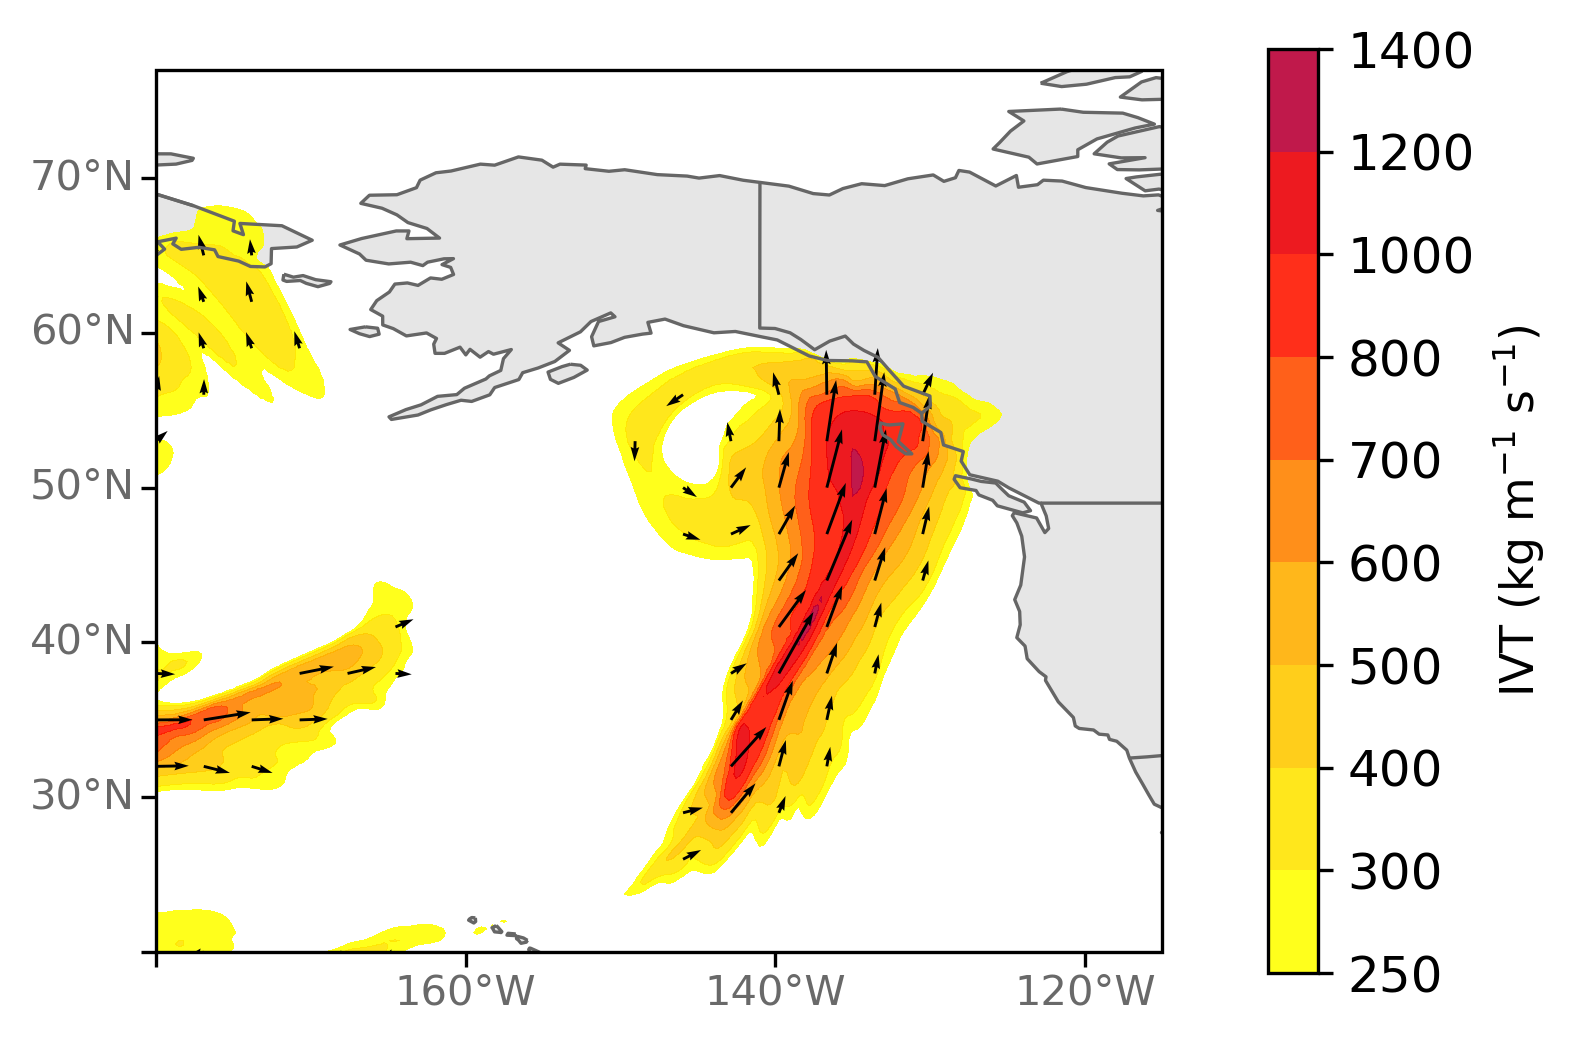

In [ ]:
# Create figure
fig = plt.figure(figsize=(5, 4))
fig.dpi = 300
fname = path_to_figs + 'schematic_{0}'.format(casename)
fmt = 'png'

nrows = 1
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 0.05], wspace=0.2, hspace=0.05)
## use gs[rows index, columns index] to access grids

### first column plot - AR on Dec 1, 2020
ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext1, xticks=dx1, yticks=dy1, left_lats=True, right_lats=False, mask_ocean=False, coastline=True)

# Contour Filled
lats = ds.lat.values
lons = ds.lon.values
ivt = ds.IVT.values
cmap, norm, bnds = ccmap.cmap('ivt')
cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                 levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')

# Wind barbs / vectors 
uvec = ds.uIVT.values
vvec = ds.vIVT.values
uvec_mask = ds.uIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
vvec_mask = ds.vIVT.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
          color='k', regrid_shape=20,
          angles='xy', scale_units='xy', scale=250, units='xy')

# quiver key
qk = ax.quiverkey(Q, 0.01, -0.16, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})

# Add color bar
cbax = plt.subplot(gs[0,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()